In [152]:
# ===== imports & constants =====
from pathlib import Path
import os, random, json
from collections import Counter, defaultdict
from typing import List, Tuple, Optional

import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from nltk.translate.bleu_score import corpus_bleu
from torchvision import models
import torch.optim as optim


In [172]:
# Download punkt tokenizer (only once)

# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

DEVICE           = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMAGE_DIR        = Path("Flickr8k_Dataset_2") / "Flicker8k_Dataset"
TEXT_DIR         = Path("Flickr8k_TEXT")
TOKEN_FILE       = TEXT_DIR / "Flickr8k.token.txt"
TRAIN_SPLIT      = TEXT_DIR / "Flickr_8k.trainImages.txt"
DEV_SPLIT        = TEXT_DIR / "Flickr_8k.devImages.txt"
TEST_SPLIT       = TEXT_DIR / "Flickr_8k.testImages.txt"

print("Image folder:", IMAGE_DIR)
print("Train split:", TRAIN_SPLIT)
print("Dev split:  ", DEV_SPLIT)
print("Test split: ", TEST_SPLIT)
print("Caption file:", TOKEN_FILE)


Image folder: Flickr8k_Dataset_2/Flicker8k_Dataset
Train split: Flickr8k_TEXT/Flickr_8k.trainImages.txt
Dev split:   Flickr8k_TEXT/Flickr_8k.devImages.txt
Test split:  Flickr8k_TEXT/Flickr_8k.testImages.txt
Caption file: Flickr8k_TEXT/Flickr8k.token.txt


In [173]:
# Model hyper-parameters

# -------- model / optimisation ----------
ENCODER_BACKBONE = "resnet34"   # <<<<<<  smaller CNN
ENCODE_SIZE      = 14           # spatial size after adaptive pooling
EMBED_DIM        = 256
DECODER_DIM      = 256
ATTENTION_DIM    = 256
ENCODER_DIM      = 512          # ResNet-34 final feature depth
FINE_TUNE_ENCOD  = True         # fine-tune 2 last blocks

BATCH_SIZE       = 24           # fits easily in 10 GB for ResNet-34
NUM_EPOCHS       = 20
DEC_LR, ENC_LR   = 4e-4, 1e-5
GRAD_CLIP        = 5.0
BEAM_SIZE        = 3

In [174]:
# Cell 2: Count how many .jpg files we have, and load the split lists

# Count .jpg files
all_images = list(IMAGE_DIR.glob("*.jpg"))
print(f"Total .jpg files under {IMAGE_DIR}: {len(all_images)}")

def load_split(fp):        # read file names
    return set(Path(fp).read_text().strip().split())

train_imgs = load_split(TRAIN_SPLIT)
dev_imgs   = load_split(DEV_SPLIT)
test_imgs  = load_split(TEST_SPLIT)

# raw captions (“img#idx <TAB> caption”)
captions_dict = defaultdict(list)
for line in Path(TOKEN_FILE).read_text(encoding="utf-8").splitlines():
    key, sent = line.split("\t")
    img = key.split("#")[0]
    captions_dict[img].append(sent.split())        # store as token list
print("Loaded:",
      f"{len(train_imgs)} train imgs,",
      f"{len(dev_imgs)} dev imgs,",
      f"{len(test_imgs)} test imgs")



Total .jpg files under Flickr8k_Dataset_2/Flicker8k_Dataset: 8091
Loaded: 6000 train imgs, 1000 dev imgs, 1000 test imgs


In [178]:
# Vocabulary (no extra tokenization)
class Vocabulary:
    def __init__(self, min_freq=5):
        self.stoi = {"<PAD>":0, "<SOS>":1, "<EOS>":2, "<UNK>":3}
        self.itos = {i:s for s,i in self.stoi.items()}
        self.min_freq = min_freq
        
    def __len__(self):
        return len(self.stoi)

    def build(self, caption_lists):
        freq = Counter(tok for cap in caption_lists for tok in cap)
        idx = 4
        for w,c in freq.items():
            if c >= self.min_freq:
                self.stoi[w] = idx
                self.itos[idx] = w
                idx += 1

    def encode(self, tokens):
        return [self.stoi.get(t, self.stoi["<UNK>"]) for t in tokens]

vocab = Vocabulary(5)
vocab.build([cap for img in train_imgs for cap in captions_dict[img]])
print("Vocabulary size:", len(vocab))



Vocabulary size: 2620


In [180]:
class FlickrDataset(Dataset):
    def __init__(self, img_dir, img_names, caps_dict, vocab, transform=None, max_len=50):
        self.samples = [(n, cap) for n in img_names for cap in caps_dict[n]]
        self.dir, self.vocab, self.t, self.max = img_dir, vocab, transform, max_len

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        name, tokens = self.samples[idx]
        img = Image.open(self.dir/name).convert("RGB")
        if self.t: img = self.t(img)
        ids = [1]+self.vocab.encode(tokens)+[2]           # <SOS> ... <EOS>
        ids = torch.tensor(ids[:self.max], dtype=torch.long)
        return img, ids

def collate(batch):
    imgs, caps = zip(*batch)
    imgs = torch.stack(imgs)
    cap_lens = torch.tensor([len(c) for c in caps])
    caps_pad = nn.utils.rnn.pad_sequence(caps, batch_first=True,
                                         padding_value=vocab.stoi["<PAD>"])
    return imgs, caps_pad, cap_lens


In [181]:
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

train_ds = FlickrDataset(IMAGE_DIR, train_imgs, captions_dict, vocab, transform)
dev_ds   = FlickrDataset(IMAGE_DIR, dev_imgs,   captions_dict, vocab, transform)

train_loader = DataLoader(train_ds, BATCH_SIZE, shuffle=True,
                          num_workers=4, pin_memory=True, collate_fn=collate)
dev_loader   = DataLoader(dev_ds, BATCH_SIZE, shuffle=False,
                          num_workers=4, pin_memory=True, collate_fn=collate)

print("Pairs:", len(train_ds), "train  |  ", len(dev_ds), "val")


Pairs: 30000 train  |   5000 val


In [184]:
# Encoder (ResNet-34)

class Encoder(nn.Module):
    def __init__(self, encoded_image_size=14, fine_tune=True):
        super().__init__()
        resnet = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
        self.cnn = nn.Sequential(*list(resnet.children())[:-2])     # remove avg-pool & fc
        self.pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))
        self.enc_dim = 512
        # fine-tune only last 2 layers
        for p in self.cnn.parameters(): p.requires_grad = False
        if fine_tune:
            for child in list(self.cnn.children())[-4:]:
                for p in child.parameters(): p.requires_grad = True

    def forward(self, x):
        x = self.pool(self.cnn(x))          # (B, 512, E, E)
        return x.permute(0,2,3,1)           # (B, E, E, 512)


In [190]:
# Attention & Decoder

class Attention(nn.Module):
    def __init__(self, enc_dim, dec_dim, att_dim):
        super().__init__()
        self.enc_fc = nn.Linear(enc_dim, att_dim)
        self.dec_fc = nn.Linear(dec_dim, att_dim)
        self.full   = nn.Linear(att_dim, 1)
        self.relu   = nn.ReLU()
        self.sm     = nn.Softmax(dim=1)

    def forward(self, enc_out, h):
        # enc_out: (B, num_pix, enc_dim)
        att = self.full(self.relu(self.enc_fc(enc_out) + self.dec_fc(h).unsqueeze(1))).squeeze(2)
        alpha = self.sm(att)                               # (B, num_pix)
        context = (enc_out * alpha.unsqueeze(2)).sum(1)    # (B, enc_dim)
        return context, alpha

class DecoderWithAttention(nn.Module):
    def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size,
                 enc_dim=512, dropout=0.5, max_len=50):
        super().__init__()
        self.att = Attention(enc_dim, decoder_dim, attention_dim)
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.lstm  = nn.LSTMCell(embed_dim+enc_dim, decoder_dim)
        self.fc    = nn.Linear(decoder_dim, vocab_size)
        self.init_h = nn.Linear(enc_dim, decoder_dim)
        self.init_c = nn.Linear(enc_dim, decoder_dim)
        self.f_beta = nn.Linear(decoder_dim, enc_dim)
        self.sigmoid= nn.Sigmoid()
        self.dropout= nn.Dropout(dropout)
        self.max_len= max_len
        # init weights
        nn.init.uniform_(self.embed.weight, -0.1, 0.1)

    def init_hidden(self, enc_out):
        mean = enc_out.mean(1)
        return self.init_h(mean), self.init_c(mean)

    def forward(self, enc_feat, caps, cap_len):
        """
        enc_feat : (B, E, E, enc_dim)  – output from Encoder
        caps     : (B, max_seq)        – padded captions incl. <SOS>/<EOS>
        cap_len  : (B,)                – original lengths
        """
        B = enc_feat.size(0)
        enc_feat = enc_feat.view(B, -1, enc_feat.size(-1))          # (B, num_pix, enc_dim)
        num_pix  = enc_feat.size(1)

        # sort by length (required for pack-style loop)
        cap_len, sort_idx = cap_len.sort(dim=0, descending=True)
        enc_feat  = enc_feat[sort_idx]
        caps      = caps[sort_idx]

        # embed all tokens up-front
        embeddings = self.embed(caps)                               # (B, max_len, embed_dim)
        h, c = self.init_hidden(enc_feat)                           # (B, dec_dim)

        max_t = (cap_len - 1).max()                                 # ignore <EOS>
        preds  = torch.zeros(B, max_t, len(vocab)).to(DEVICE)
        alphas = torch.zeros(B, max_t, num_pix).to(DEVICE)

        for t in range(max_t):
            batch_t = (cap_len - 1 > t).sum().item()                # active samples
            context, alpha = self.att(enc_feat[:batch_t], h[:batch_t])

            gate    = self.sigmoid(self.f_beta(h[:batch_t]))        # gating
            context = gate * context

            lstm_in = torch.cat([embeddings[:batch_t, t, :], context], dim=1)
            h_new, c_new = self.lstm(lstm_in, (h[:batch_t], c[:batch_t]))

            # ------     clone before slice-assignment (no in-place)     ------
            h = h.clone(); c = c.clone()
            h[:batch_t] = h_new
            c[:batch_t] = c_new
            # -----------------------------------------------------------------

            preds [:batch_t, t, :] = self.fc(self.dropout(h_new))
            alphas[:batch_t, t, :] = alpha

        return preds, caps, cap_len-1, alphas


In [191]:
# Instantiate & Optimisers

encoder = Encoder(encoded_image_size=ENCODE_SIZE,
                  fine_tune=FINE_TUNE_ENCOD).to(DEVICE)

decoder = DecoderWithAttention(
    attention_dim = ATTENTION_DIM,
    embed_dim     = EMBED_DIM,
    decoder_dim   = DECODER_DIM,
    vocab_size    = len(vocab),
    enc_dim       = ENCODER_DIM,
    dropout       = 0.5
).to(DEVICE)

criterion = nn.CrossEntropyLoss(ignore_index=vocab.stoi["<PAD>"])
dec_opt   = torch.optim.Adam(decoder.parameters(), lr=DEC_LR)
enc_opt   = torch.optim.Adam(filter(lambda p: p.requires_grad, encoder.parameters()),
                             lr=ENC_LR) if FINE_TUNE_ENCOD else None


In [192]:
# Training Utilities

def train_one_epoch(loader, encoder, decoder, criterion, enc_opt, dec_opt, epoch):
    encoder.train(); decoder.train(); running=0
    for imgs, caps, cap_len in loader:
        imgs,caps,cap_len = imgs.to(DEVICE),caps.to(DEVICE),cap_len.to(DEVICE)
        # forward
        enc = encoder(imgs)
        scores, caps_sorted, decode_lens, alphas = decoder(enc, caps, cap_len)
        targets = caps_sorted[:,1:]           # remove <SOS>
        scores = torch.cat([scores[i,:l] for i,l in enumerate(decode_lens)], 0)
        targets= torch.cat([targets[i,:l] for i,l in enumerate(decode_lens)], 0)
        loss = criterion(scores, targets) + 1.0*((1-alphas.sum(1))**2).mean()
        # backprop
        dec_opt.zero_grad(); 
        if enc_opt: enc_opt.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(decoder.parameters(), GRAD_CLIP)
        if enc_opt: nn.utils.clip_grad_norm_(encoder.parameters(), GRAD_CLIP)
        dec_opt.step(); 
        if enc_opt: enc_opt.step()
        running += loss.item()
    return running/len(loader)


In [193]:
# Simple BLEU-4 Validation

@torch.no_grad()
def evaluate_bleu(loader, encoder, decoder, vocab):
    encoder.eval(); decoder.eval()
    refs, hyps = [], []
    for imgs, caps, _ in loader:
        imgs = imgs.to(DEVICE)
        enc  = encoder(imgs)
        enc  = enc.view(imgs.size(0), -1, ENCODER_DIM)
        # greedy decode
        B = imgs.size(0)
        h,c = decoder.init_hidden(enc)
        prev = torch.full((B,1), vocab.stoi["<SOS>"], dtype=torch.long, device=DEVICE)
        seqs = [[] for _ in range(B)]
        for _ in range(50):
            emb = decoder.embed(prev).squeeze(1)
            ctx,_ = decoder.att(enc, h)
            gate  = decoder.sigmoid(decoder.f_beta(h)); ctx = gate*ctx
            h,c   = decoder.lstm(torch.cat([emb,ctx],1), (h,c))
            out   = decoder.fc(h)
            nextw = out.argmax(1, keepdim=True)     # greedy
            prev  = nextw
            for i,w in enumerate(nextw.squeeze(1).tolist()):
                if w == vocab.stoi["<EOS>"]: continue
                seqs[i].append(w)
        # collect refs/hyps
        for gt in caps:
            refs.append([[w for w in gt.tolist() if w not in {0,1,2,3}]])
        hyps.extend(seqs)
    return corpus_bleu(refs, hyps)



In [194]:
# Training Loop (+ checkpoint)

best_bleu = 0.0
for epoch in range(1, NUM_EPOCHS+1):
    loss = train_one_epoch(train_loader, encoder, decoder,
                           criterion, enc_opt, dec_opt, epoch)
    bleu = evaluate_bleu(dev_loader, encoder, decoder, vocab)
    print(f"Epoch {epoch:2d} | loss {loss:.4f} | BLEU-4 {bleu:.4f}")
    if bleu > best_bleu:
        best_bleu = bleu
        torch.save({
            "enc": encoder.state_dict(),
            "dec": decoder.state_dict(),
            "vocab": vocab.stoi,
            "bleu": best_bleu
        }, "best_ckpt_res34.pth")
        print("  ↳ New best, checkpoint saved.")


Epoch  1 | loss 4.8791 | BLEU-4 0.0152
  ↳ New best, checkpoint saved.
Epoch  2 | loss 4.1014 | BLEU-4 0.0192
  ↳ New best, checkpoint saved.
Epoch  3 | loss 3.8299 | BLEU-4 0.0201
  ↳ New best, checkpoint saved.
Epoch  4 | loss 3.6563 | BLEU-4 0.0216
  ↳ New best, checkpoint saved.
Epoch  5 | loss 3.5296 | BLEU-4 0.0219
  ↳ New best, checkpoint saved.
Epoch  6 | loss 3.4255 | BLEU-4 0.0220
  ↳ New best, checkpoint saved.
Epoch  7 | loss 3.3411 | BLEU-4 0.0224
  ↳ New best, checkpoint saved.
Epoch  8 | loss 3.2669 | BLEU-4 0.0235
  ↳ New best, checkpoint saved.
Epoch  9 | loss 3.2016 | BLEU-4 0.0238
  ↳ New best, checkpoint saved.
Epoch 10 | loss 3.1424 | BLEU-4 0.0227
Epoch 11 | loss 3.0882 | BLEU-4 0.0258
  ↳ New best, checkpoint saved.
Epoch 12 | loss 3.0385 | BLEU-4 0.0261
  ↳ New best, checkpoint saved.
Epoch 13 | loss 2.9884 | BLEU-4 0.0277
  ↳ New best, checkpoint saved.
Epoch 14 | loss 2.9459 | BLEU-4 0.0274
Epoch 15 | loss 2.9077 | BLEU-4 0.0270
Epoch 16 | loss 2.8656 | BLEU-4

In [200]:
# =====================================================================================
# Post-training:  load the best checkpoint and run evaluation / caption generation
# =====================================================================================
import torch, json, hashlib
from pathlib import Path
from torch.utils.data import DataLoader
from collections import OrderedDict
from nltk.translate.bleu_score import corpus_bleu
from PIL import Image
import torchvision.transforms as T

CKPT_PATH   = Path("best_ckpt_res34.pth")          # change if you renamed it
DEVICE      = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BEAM_SIZE   = 3
MAX_LEN     = 50

assert CKPT_PATH.is_file(), f"Checkpoint not found: {CKPT_PATH.resolve()}"
ckpt = torch.load(CKPT_PATH, map_location=DEVICE)  # weights_only=True is OK too

# ---------- 1. rebuild model skeletons EXACTLY as during training ----------
encoder = Encoder(encoded_image_size=ENCODE_SIZE, fine_tune=False).to(DEVICE)
decoder = DecoderWithAttention(
    attention_dim = ATTENTION_DIM,
    embed_dim     = EMBED_DIM,
    decoder_dim   = DECODER_DIM,
    vocab_size    = len(ckpt["vocab"]),
    enc_dim       = ENCODER_DIM,
    dropout       = 0.0,                # no dropout at test time
).to(DEVICE)

# ---------- 2. handle "cnn." → "backbone." mismatch, if any ----------
enc_state = ckpt["enc"]
if not next(iter(enc_state)).startswith("cnn."):           # keys = backbone.* ?
    enc_state = {k.replace("backbone.", "cnn."): v for k, v in enc_state.items()}
missing, unexpected = encoder.load_state_dict(enc_state, strict=False)
decoder.load_state_dict(ckpt["dec"])
encoder.eval(); decoder.eval()
for p in (*encoder.parameters(), *decoder.parameters()):
    p.requires_grad_(False)

print(f"✓ weights loaded  |  missing={len(missing)} unexpected={len(unexpected)}")

# ---------- 3. rebuild Vocabulary from checkpoint ----------
class Vocabulary:
    def __init__(self, stoi):
        self.stoi = stoi
        self.itos = {i:w for w,i in stoi.items()}
    def __len__(self): return len(self.stoi)
    def encode(self, toks): return [self.stoi.get(t, self.stoi["<UNK>"]) for t in toks]
vocab = Vocabulary(ckpt["vocab"])          # same interface as before

# ---------- 4. test-split DataLoader ----------
test_ds   = FlickrDataset(IMAGE_DIR, test_imgs, captions_dict, vocab, transform)
test_loader = DataLoader(test_ds, BATCH_SIZE, shuffle=False,
                         num_workers=4, pin_memory=True, collate_fn=collate)

# ---------- 5a. corpus-level BLEU-4 on held-out test set ----------
@torch.no_grad()
def test_bleu(loader):
    encoder.eval(); decoder.eval()
    refs, hyps = [], []
    for imgs, caps, _ in loader:
        imgs = imgs.to(DEVICE)
        enc  = encoder(imgs).view(imgs.size(0), -1, ENCODER_DIM)
        B    = imgs.size(0)
        h,c  = decoder.init_hidden(enc)
        prev = torch.full((B,1), vocab.stoi["<SOS>"], dtype=torch.long, device=DEVICE)
        seqs = [[] for _ in range(B)]

        for _ in range(MAX_LEN):
            emb     = decoder.embed(prev).squeeze(1)
            ctx,_   = decoder.att(enc, h)
            gate    = decoder.sigmoid(decoder.f_beta(h)); ctx = gate*ctx
            h,c     = decoder.lstm(torch.cat([emb,ctx],1), (h,c))
            next_w  = decoder.fc(h).argmax(1, keepdim=True)
            prev    = next_w
            for i,w in enumerate(next_w.squeeze(1).tolist()):
                if w == vocab.stoi["<EOS>"]: continue
                seqs[i].append(w)

        # collect references/hypotheses
        for gt in caps:
            refs.append([[tok for tok in gt.tolist() if tok not in {0,1,2,3}]])
        hyps.extend(seqs)
    return corpus_bleu(refs, hyps)

bleu_test = test_bleu(test_loader)
print(f"Test BLEU-4: {bleu_test:.4f}")

# ---------- 5b. caption a single JPG/PNG ----------
preproc = T.Compose([
    T.Resize((256,256)),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])


def caption_image(img_path, beam_size=BEAM_SIZE, max_len=MAX_LEN):
    """
    Generate a caption for one image with beam search (beam_size=k).
    Works with your existing Encoder / DecoderWithAttention.
    """
    # --- image to encoder features ---
    img  = preproc(Image.open(img_path).convert("RGB")).unsqueeze(0).to(DEVICE)
    enc  = encoder(img).view(1, -1, ENCODER_DIM)          # (1, num_pix, enc_dim)

    # --- init k beams ---
    k           = beam_size
    vocab_size  = len(vocab)
    start_tok   = vocab.stoi["<SOS>"]
    end_tok     = vocab.stoi["<EOS>"]

    seqs   = torch.full((k,1), start_tok, dtype=torch.long, device=DEVICE)  # (k,1)
    scores = torch.zeros(k,1, device=DEVICE)                                # (k,1)

    enc    = enc.expand(k, *enc.shape[1:])   # copy encoder output k times
    h, c   = decoder.init_hidden(enc)        # (k, dec_dim)

    complete = []                            # finished beams

    for _ in range(max_len):
        # ------------------------------------------------------------------
        # ONE decoding step for every live beam – all inline, no .step()
        # ------------------------------------------------------------------
        emb      = decoder.embed(seqs[:,-1]).squeeze(1)      # (k, embed_dim)
        context, _ = decoder.att(enc, h)                     # (k, enc_dim)
        gate     = decoder.sigmoid(decoder.f_beta(h))
        context  = gate * context
        h, c     = decoder.lstm(torch.cat([emb, context], 1), (h, c))
        preds    = decoder.fc(h)                             # (k, vocab)
        log_p    = preds.log_softmax(dim=-1)

        # ------------------------------------------------------------------
        # add scores from previous steps and select top-k
        # ------------------------------------------------------------------
        scores_expand         = scores.expand_as(log_p)      # (k, vocab)
        topk_scores, topk_words = (scores_expand + log_p).view(-1).topk(k)

        prev_beam = topk_words // vocab_size                 # which beam they came from
        next_word = topk_words  % vocab_size                 # next token id

        # append new words to corresponding beams
        seqs  = torch.cat([seqs[prev_beam], next_word.unsqueeze(1)], 1)  # (k, t+1)
        scores= topk_scores.unsqueeze(1)                                   # (k,1)

        # keep track of completed beams
        alive   = []
        for i, w in enumerate(next_word):
            if w.item() == end_tok:
                complete.append((seqs[i], scores[i]))
            else:
                alive.append(i)

        # if all beams ended, stop early
        if not alive:
            break

        # prune to the alive beams only
        seqs   = seqs[alive]
        scores = scores[alive]
        enc    = enc[alive]
        h      = h[alive]
        c      = c[alive]
        k      = len(alive)

    # pick best finished beam
    if complete:
        best = max(complete, key=lambda x: x[1])[0]
    else:           # none finished within max_len
        best = seqs[0]

    # convert ids → words, strip <SOS>/<EOS>
    caption = " ".join(
        vocab.itos[idx.item()]
        for idx in best[1:]
        if idx.item() not in {start_tok, end_tok}
    )
    return caption



/tmp/ipykernel_205247/3938172048.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(CKPT_PATH, map_location=DEVICE)  # weights_only=True is OK too


✓ weights loaded  |  missing=0 unexpected=0
Test BLEU-4: 0.0278


In [215]:
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

# Change this to wherever your images live
IMAGE_DIR = Path("Flickr8k_Dataset_2") / "Flicker8k_Dataset"

def picture(filename: str):
    
    img_path = IMAGE_DIR / filename
    if img_path.is_file():
        img = Image.open(img_path).convert("RGB")
        plt.imshow(img)
        plt.title(str(img_path))
        plt.axis('off')
        plt.show()
    else:
        print(f"File not found: {img_path.resolve()}")


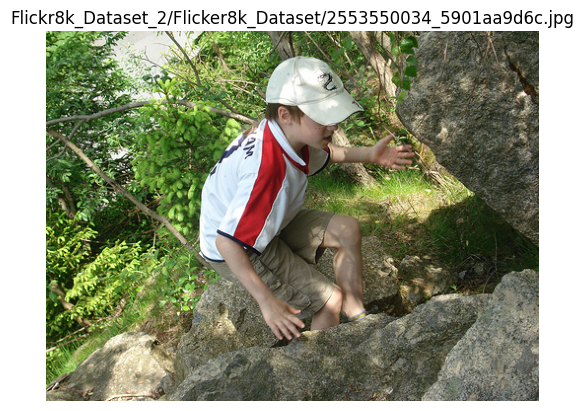

A man in a red hat is holding a rope .


In [216]:
# Example:
picture("2553550034_5901aa9d6c.jpg")
print(caption_image("Flickr8k_Dataset_2/Flicker8k_Dataset/2553550034_5901aa9d6c.jpg"))


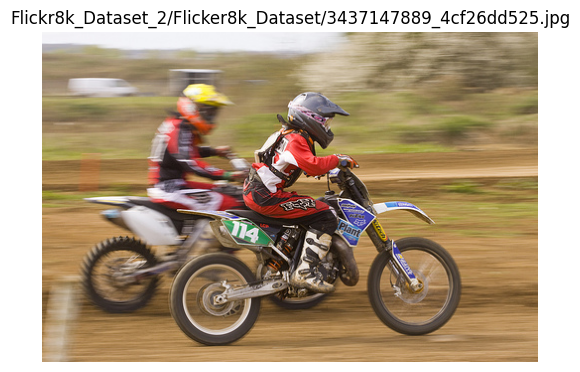

Two men are riding a dirt bike in the dirt .


In [217]:
picture("3437147889_4cf26dd525.jpg")
print(caption_image("Flickr8k_Dataset_2/Flicker8k_Dataset/3437147889_4cf26dd525.jpg"))


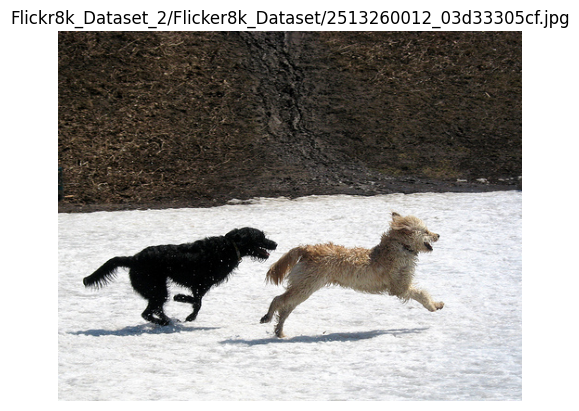

Two dogs run across a snowy field .


In [219]:

picture("2513260012_03d33305cf.jpg")
print(caption_image("Flickr8k_Dataset_2/Flicker8k_Dataset/2513260012_03d33305cf.jpg"))